## References
* [Cython documentation](http://docs.cython.org/en/latest/)
* [An Interactive Introduction to Cython by Chris Swierczewski](http://www.cswiercz.info)
* [Introduction To Python by Michael Kraus](http://michael-kraus.org/introduction-to-python.html)
* [Cython by Xavier Juvigny (🇫🇷)](http://calcul.math.cnrs.fr/IMG/pdf/cythontalk.pdf)

![Cython logo](http://upload.wikimedia.org/wikipedia/en/thumb/c/ce/Cython-logo.svg/440px-Cython-logo.svg.png)

* Cython  provides extra syntax allowing for static type declarations (remember: Python is generally dynamically typed)
* Python code gets translated into optimised C/C++ code and compiled as Python extension modules
* Cython allows you to write fast C code in a Python-like syntax. 
* Furthermore, linking to existing C libraries is simplified.

```sh
pip install cython
```
or
```sh
conda install cython
```

In [1]:
%load_ext Cython

# C Variable and Type definitions

In general, use `cdef` to declare C variables. 
The command :
```sh
$ cython -a mycode.pyx
```
outputs an html file. It shows what parts of your code are C, which parts are Python, and where C-Python conversion occurs.

In [2]:
%%cython -a
cdef int i, j = 2, k = 3      # assigning values at declaration
i = 1                         # assigning values afterwards
# avoid Python-C conversion! It's expensive:
a = 5
i = a
# same with C-Python conversion:
b = j
print("a = %d" % a)
print("i = %d" % i)
print("b = %d" % b)

a = 5
i = 5
b = 2


In [3]:
%%cython -a
#
# another Python vs. Cython coloring guide:
#
cdef int m
cdef int n
cdef double cy_total = 0.0
for m in range(10):
    n = 2*m
    cy_total += n
a = 0
b = 0
py_total = 0.0
for a in range(10):
    b = 2*a
    py_total += b
print(cy_total)
print(py_total)

90.0
90.0


In [4]:
%%cython -a
#
# Advanced Types
#
cdef struct Grail:
    int age
    float volume
cdef union Food:
    char *spam
    float *eggs
cdef enum CheeseType:
    cheddar, edam,
    camembert
cdef enum CheeseState:
    hard = 1
    soft = 2
    runny = 3
cdef Grail holy
holy.age    = 500
holy.volume = 10.0
print (holy.age, holy.volume)



500 10.0


# Cython Functions

Use **cdef** to define a Cython function.   
 - Cython function can accept either (inclusive) Python and C values as well as return either Python or C values,
 - *Within a Cython module* Python and Cython functions can call each other freely. However, only **Python** functions can be called from outside the module by Python code. (i.e. importing/exporting a Cython module into some Python code)

**cpdef** define a Cython function with a simple Python wrapper. However, when called from Cython the Cython / C code is called directly, bypassing the Python wrapper.  

In [5]:
%%cython
#
# Simply writing Python code in Cython gives about a 
# 35% speed boost. Note that none of the code below is 
# Cython-specific.
def f(x):
    return x**2 - x
def integrate_f(a, b, N):
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

0 0 2 6


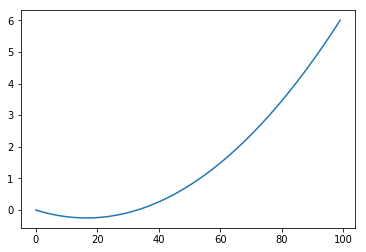

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
print (f(0), f(1), f(2), f(3))
plt.plot(f(np.linspace(0,3,100)))

In [7]:
def integrate_f_py(a,b,N):
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

In [8]:
%timeit integrate_f_py(0,3,10**3)

210 µs ± 5.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit integrate_f(0,3,10**3)

209 µs ± 3.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%cython
#
# Now use Cython types and coerce Python types to C types 
# when calling the function. Still a "Python function" so 
# callable from the global namespace.
#
def f(x):
    return x**2 - x
def cy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i*dx)
    return s*dx

Approximately 2 times speedup over pure Python.

In [11]:
%timeit cy_integrate_f(0,3,10**3)

106 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Finally, we integrate a Cython function instead of a Python function. This eliminates the Python-C conversion at the function call as seen above thus giving a pure Cython/C algorithm.

The primary downside is not being allowed to call
the function, $f$, from Python unless `cpdef` is
used. 


In [12]:
%%cython
cdef double cy_f(double x):
     return x**2 - x
def cycy_integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, dx
    s  = 0
    dx = (b - a) / N
    for i in range(N):
        s += cy_f(a + i*dx)
    return s*dx

In [13]:
%timeit integrate_f_py(0,3,10**3)

219 µs ± 3.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit integrate_f(0,3,10**3)

202 µs ± 5.26 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit cy_integrate_f(0,3,10**3)

114 µs ± 5.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit cycy_integrate_f(0,3,10**3)

1.39 µs ± 32.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Approximately 150 times speedup from pure Python

# Cython and Numpy

The Numpy library contains many fast numerics routines. Their speed comes from manipulating the low-level C-arrays that the numpy.array object wraps rather than computing over slow Python lists. Using Cython one can access those low-level arrays and implement their own fast algorithms while allowing the easy interaction afforded by Python + Numpy.

The examples below are various implementations of the naive matrix multiplication algorithm. We will start with a pure Python implementation and then incrementally add structures that allow Cython to exploit the low-level speed of the numpy.array object.

### Pure Python implementation compiled in Cython specific optimizations.

In [54]:
%%cython

def matmul0(A, B, out=None):
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out



We now take advantage of the ability to access the underlying C arrays in the `numpy.array` object from Cython, thanks to a special `numpy.pxd` file included with Cython. (The Cython developers worked closely with Numpy developers to make this optimal.) 
To begin with, we have to `cimport` numpy: that is, import numpy as a **Cython** module rather than a **Python** module. To do so, simply type:

```python
cimport numpy as np
```
Another important thing to note is the type of Numpy indexers. There is a special Numpy variable type used for `numpy.array` indices called `Py_ssize_t`. To take full advantage of the speedups that Cython can provide we should make sure to type the variables used for indexing as such.


In [55]:
%%cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t      # shorthand type. easy to change
def matmul2(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

In [56]:
import numpy as np
from timeit import timeit
A = np.random.random_sample((64,64))
B = np.random.random_sample((64,64))
C = np.zeros((64,64))

In [57]:
%timeit matmul0(A,B,C)

74.6 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
%timeit matmul2(A,B,C)

340 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Tuning indexing further¶
The array lookups are still slowed down by two factors:
  * Bounds checking is performed.
  * Negative indices are checked for and handled correctly. 
  
The code doesn’t use negative indices, and always access to arrays within bounds. We can add a decorator to disable bounds checking:

In [61]:
%%cython
cimport cython                                       # cython tools
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def matmul3(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] out=None):
    cdef Py_ssize_t i, j, k
    cdef dtype_t s
    assert A.shape[1] == B.shape[0]
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = 0
            for k in range(A.shape[1]):
                s += A[i,k] * B[k,j]
            out[i,j] = s
    return out

In [64]:
%timeit matmul3(A,B,C)

207 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Now it is time to invoke BLAS. This serves as an exercise in using Numpy objects with external C libraries. Note that this can actually be slower for small matrices / data objects due to extra Python object construction; namely, the separate row/col.  

In [86]:
%%cython

cdef extern from "mydgemm.c":
    void my_dgemm (int m, int n, int k, 
                          double *A, double *B, double *C)
    
cimport cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t
@cython.boundscheck(False)
@cython.wraparound(False) 
def matmul4(np.ndarray[dtype_t, ndim=2] A,
            np.ndarray[dtype_t, ndim=2] B,
            np.ndarray[dtype_t, ndim=2] C=None):
    cdef int m = A.shape[0]
    cdef int n = A.shape[1]
    cdef int k = B.shape[1]
    cdef dtype_t s
    
    my_dgemm(m, n, k, &A[0,0], &B[0,0], &C[0,0])
                                                  
    return C

CompileError: command 'clang' failed with exit status 1

In [84]:
def exp_python(x,terms=50):
   sum = 0.
   power = 1.
   fact = 1.
   for i in range(terms):
      sum += power/fact
      power *= x
      fact *= i+1
   return sum

In [25]:
%%cython
def exp_cython(double x, int terms = 50):
   cdef double sum
   cdef double power
   cdef double fact
   cdef int i
   sum = 0.
   power = 1.
   fact = 1.
   for i in range(terms):
      sum += power/fact
      power *= x
      fact *= i+1
   return sum


In [28]:
%timeit exp_python(1.,50)

7.68 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
%timeit exp_cython(1.,50)

155 ns ± 4.94 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [30]:
def is_prime0(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [31]:
L = list(range(10000))
%timeit [is_prime0(p) for p in L]

9.14 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%%cython
def is_prime1(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [34]:
%timeit [is_prime1(p) for p in L]

4.1 ms ± 228 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%%cython
import cython
@cython.locals(n=int, k=int)
def is_prime2(n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

In [36]:
%timeit [is_prime2(p) for p in L]

821 µs ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
%%cython
import cython
cdef bint is_prime3(int n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True
def is_prime_list(L):
    return [is_prime3(p) for p in L]

In [39]:
%timeit is_prime_list(L)

326 µs ± 25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%%cython
import cython
from numpy cimport ndarray
import numpy

cdef bint is_prime3(int n):
    if n == 2: return True
    if n % 2 == 0 or n < 2: return False
    cdef int k = 3
    while k*k <= n:
        if n % k == 0: return False
        k += 2
    return True

def is_prime_array(ndarray[int, ndim=1] L):
    cdef ndarray[int, ndim=1] res = ndarray(shape=(L.shape[0]),dtype=numpy.int32)
    cdef int i
    for i in xrange(L.shape[0]):
        res[i] = is_prime3(L[i])
    return res



In [41]:
import numpy
npL = numpy.array(L,dtype=numpy.int32)
%timeit is_prime_array(npL)



256 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
